#  In Depth: Principal Component Analysis

- We explore one of the most popular unsupervised algorithms, principal component analysis (PCA). PCA is fundamentally a dimensionality reduction algorithm for visualization but has many other uses.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Introducing Principal Component Analysis
- Consider the following 200 points:

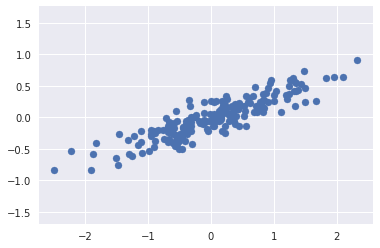

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

- There clearly is a linear relationship between x and y. Instead of trying to *predict* y from x, the unsupervised learning problem attempts to learn about the *relationship* between x and y.

- This relationship is quantified in PCA by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

- The fit() returns the "components" and "explained variance" characteristics.

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[ 0.7625315  0.0184779]


- Visualize the axes as vectors over the input data, using the "components" to define their directions, and the "explained variance" to define their squared-lengths:

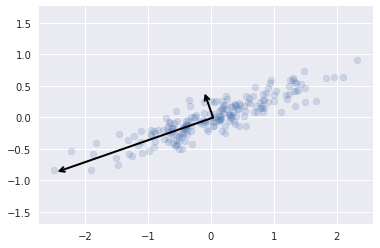

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

- The vectors are the *principal axes* of the data. The length of each vector is an indication of how "important" that axis is in describing the data's distribution. (More precisely it is a measure of the variance of the data when projected onto that axis.)
- The projection of each data point onto the principal axes are the "principal components" of the data.
- Plot these principal components beside the original data.

![](figures/05.09-PCA-rotation.png)

- The transformation from data axes to principal axes is known as a *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling.

### PCA as dimensionality reduction

- Using PCA for dimensionality reduction means zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


- The transformed data has been reduced to a single dimension.
- To understand the effect of this dimensionality reduction, plot the inverse transform of the reduced data beside the original data.

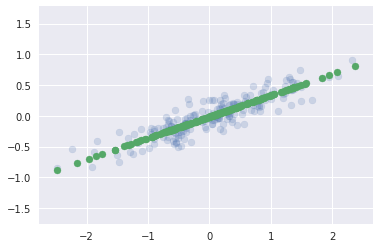

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=1.0)
plt.axis('equal');

- The light points are the original data; the dark points are the projected version.
- here's the benefit of PCA: the information along the least important principal axis or axes is removed.
- The fraction of variance that is removed is roughly a measure of how much "information" is discarded.
- This reduced-dimension dataset can be "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA for visualization: Hand-written digits

- The benefit of dimensionality reduction becomes much more apparent when looking at high-dimensional data. Let's apply PCA to the digits dataset.

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

- Use PCA to project the 8x8 (64-dimensional) images to a more manageable number.

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


- Plot the first two principal components of each point.

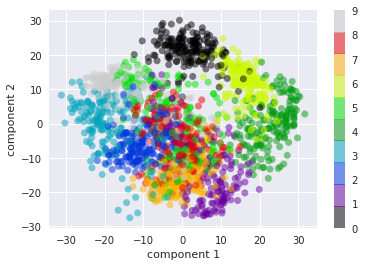

In [11]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

- Recall what these components mean: the full data is a 64-dimensional point cloud; these points are the projection of each data point along the directions with the largest variance.
- Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions - without the benefit of labels.

### What do the components mean?

- This meaning can be understood in terms of combinations of basis vectors. For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

- One way we can think about this is in terms of a pixel basis. To construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

- One way to reduce the dimension of this data is to zero out all but a few of these basis vectors. For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

![](figures/05.09-digits-pixel-components.png)

- The upper row of panels shows individual pixels; the lower row shows the cumulative contribution of these pixels to the construction of the image. Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image. Were we to continue this sequence and use all 64 pixels, we would recover the original image.

- However, a pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

- PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset. This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

![](figures/05.09-digits-pca-components.png)

- Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components!
- This is the value that PCA provides: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

- If using PCA, how many components are needed to describe the data? This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

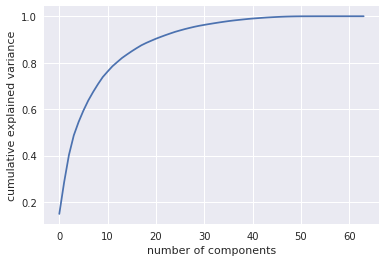

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

- This shows how much of the total (64-dimensional) variance is contained within the first $N$ components. In this dataset the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

- Our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  This helps to understand the level of redundancy present in multiple observations.

### PCA as a Noise Filter

- In this problem, any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. So if you reconstruct the data using the largest subset of principal components, you should be keeping the signal and throwing out the noise.

- Let's see how this looks with the digits data. First we will plot noise-free digits, then with random noise added.

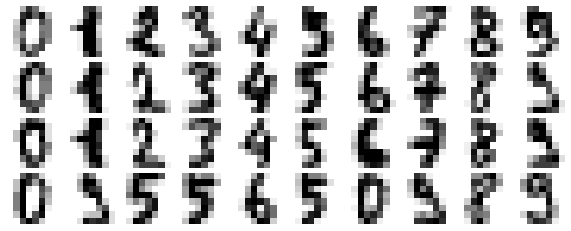

In [13]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

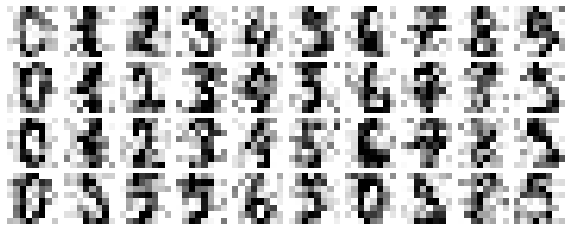

In [14]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

- It's clear that the images are noisy. Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance.

In [15]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

- Here 50% of the variance amounts to 12 principal components. Compute the components and use the inverse transform to reconstruct the filtered digits:

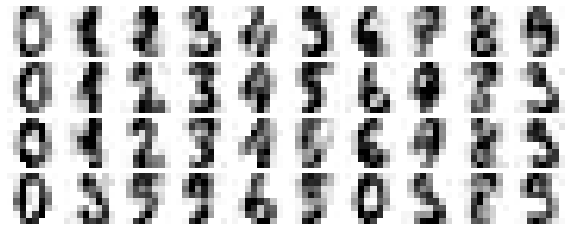

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

- This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

### Example: Eigenfaces

- Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine. Here we will take a look back and explore a bit more of what went into that. Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


- Find the principal axes that span this dataset. Because this is a large dataset, we will use ``RandomizedPCA``—it contains a randomized method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).
- View the first 150 components:

In [18]:
from sklearn.decomposition import PCA # RandomizedPCA deprecated
pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

- It can be interesting to view the images associated with the first several principal components (these components are technically known as "eigenvectors," so these types of images are often called "eigenfaces").

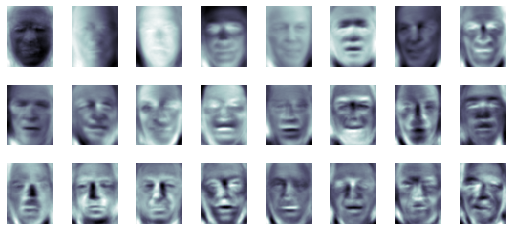

In [19]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.3, wspace=0.3))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

- The results provide insight into how the images vary. For example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
- Plot the cumulative variance of these components to see how much of the data information the projection is preserving:

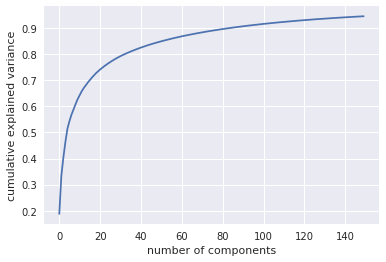

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

- 150 components account for just over 90% of the variance, so we would assume we would recover most of the essential characteristics of the data.
- Compare the input images with the images reconstructed from these 150 components.

In [21]:
# Compute the components and projected faces
pca = PCA(150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

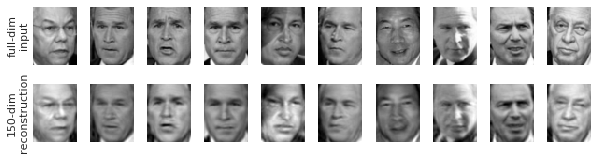

In [22]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.3, wspace=0.3))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

- The top row shows the input images; the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
- This shows why the PCA feature selection used in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) was so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.
- This says our classification algorithm can be trained on 150-dimensional data rather than 3,000-dimensional data, which can lead to a much more efficient classification.

### Summary

- Advantages:
    - Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines. Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the variances and intrinsic dimensionality.

- Weakknesses:
    - PCA tends to be highly affected by outliers in the data. For this reason, many variants have been developed.
    - ``RandomizedPCA``uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data.
    - ``SparsePCA`` introduces a regularization term (see [In Depth: Linear Regression](05.06-Linear-Regression.ipynb)) that serves to enforcthat enforces sparsity of the components.